In [5]:
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [7]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [8]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [9]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [10]:
data = data.dropna()

In [11]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [12]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, random_state=42, test_size=0.2)

In [13]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [14]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [15]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [16]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [17]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v2_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [18]:
from sentence_transformers import evaluation
import math

def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
  test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=test_evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

###Training - 1
#### stsb-distilbert-base

In [49]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:17:42 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-07-18 20:17:42 - Use pytorch device: cuda
2022-07-18 20:17:42 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:17:58 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 20:17:59 - Cosine-Similarity :	Pearson: 0.5956	Spearman: 0.5901
2022-07-18 20:17:59 - Manhattan-Distance:	Pearson: 0.5947	Spearman: 0.5882
2022-07-18 20:17:59 - Euclidean-Distance:	Pearson: 0.5969	Spearman: 0.5904
2022-07-18 20:17:59 - Dot-Product-Similarity:	Pearson: 0.5949	Spearman: 0.5843
2022-07-18 20:17:59 - Save model to binary_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:18:16 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 20:18:17 - Cosine-Similarity :	Pearson: 0.6626	Spearman: 0.6349
2022-07-18 20:18:17 - Manhattan-Distance:	Pearson: 0.6378	Spearman: 0.6325
2022-07-18 20:18:17 - Euclidean-Distance:	Pearson: 0.6411	Spearman: 0.6352
2022-07-18 20:18:17 - Dot-Product-Similarity:	Pearson: 0.6594	Spearman: 0.6332
2022-07-18 20:18:17 - Save model to binary_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:18:34 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 20:18:35 - Cosine-Similarity :	Pearson: 0.6879	Spearman: 0.6571
2022-07-18 20:18:35 - Manhattan-Distance:	Pearson: 0.6674	Spearman: 0.6546
2022-07-18 20:18:35 - Euclidean-Distance:	Pearson: 0.6708	Spearman: 0.6567
2022-07-18 20:18:35 - Dot-Product-Similarity:	Pearson: 0.6863	Spearman: 0.6550
2022-07-18 20:18:35 - Save model to binary_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:18:51 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 20:18:53 - Cosine-Similarity :	Pearson: 0.6921	Spearman: 0.6588
2022-07-18 20:18:53 - Manhattan-Distance:	Pearson: 0.6702	Spearman: 0.6571
2022-07-18 20:18:53 - Euclidean-Distance:	Pearson: 0.6745	Spearman: 0.6592
2022-07-18 20:18:53 - Dot-Product-Similarity:	Pearson: 0.6899	Spearman: 0.6568
2022-07-18 20:18:53 - Save model to binary_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:19:09 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 20:19:11 - Cosine-Similarity :	Pearson: 0.6808	Spearman: 0.6448
2022-07-18 20:19:11 - Manhattan-Distance:	Pearson: 0.6735	Spearman: 0.6442
2022-07-18 20:19:11 - Euclidean-Distance:	Pearson: 0.6758	Spearman: 0.6446
2022-07-18 20:19:11 - Dot-Product-Similarity:	Pearson: 0.6804	Spearman: 0.6422


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:19:27 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 20:19:28 - Cosine-Similarity :	Pearson: 0.6972	Spearman: 0.6577
2022-07-18 20:19:28 - Manhattan-Distance:	Pearson: 0.6863	Spearman: 0.6570
2022-07-18 20:19:28 - Euclidean-Distance:	Pearson: 0.6887	Spearman: 0.6573
2022-07-18 20:19:28 - Dot-Product-Similarity:	Pearson: 0.6971	Spearman: 0.6562


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:19:45 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 20:19:46 - Cosine-Similarity :	Pearson: 0.6963	Spearman: 0.6550
2022-07-18 20:19:46 - Manhattan-Distance:	Pearson: 0.6911	Spearman: 0.6543
2022-07-18 20:19:46 - Euclidean-Distance:	Pearson: 0.6927	Spearman: 0.6549
2022-07-18 20:19:46 - Dot-Product-Similarity:	Pearson: 0.6972	Spearman: 0.6540


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:20:02 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 20:20:04 - Cosine-Similarity :	Pearson: 0.6990	Spearman: 0.6592
2022-07-18 20:20:04 - Manhattan-Distance:	Pearson: 0.6969	Spearman: 0.6583
2022-07-18 20:20:04 - Euclidean-Distance:	Pearson: 0.6983	Spearman: 0.6589
2022-07-18 20:20:04 - Dot-Product-Similarity:	Pearson: 0.7002	Spearman: 0.6582
2022-07-18 20:20:04 - Save model to binary_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:20:21 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 20:20:22 - Cosine-Similarity :	Pearson: 0.6974	Spearman: 0.6556
2022-07-18 20:20:22 - Manhattan-Distance:	Pearson: 0.6895	Spearman: 0.6548
2022-07-18 20:20:22 - Euclidean-Distance:	Pearson: 0.6914	Spearman: 0.6550
2022-07-18 20:20:22 - Dot-Product-Similarity:	Pearson: 0.6983	Spearman: 0.6546


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:20:39 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 20:20:40 - Cosine-Similarity :	Pearson: 0.7001	Spearman: 0.6574
2022-07-18 20:20:40 - Manhattan-Distance:	Pearson: 0.6898	Spearman: 0.6570
2022-07-18 20:20:40 - Euclidean-Distance:	Pearson: 0.6919	Spearman: 0.6573
2022-07-18 20:20:40 - Dot-Product-Similarity:	Pearson: 0.7009	Spearman: 0.6566
Training done...



                     ********** stsb-distilbert-base **********
2022-07-18 20:20:40 - Load pretrained SentenceTransformer: binary_sim_output/stsb-distilbert-base
2022-07-18 20:20:41 - Use pytorch device: cuda
2022-07-18 20:20:41 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:20:41 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:20:42 - Cosine-Similarity :	Pearson: 0.6990	Spearman: 0.6592
2022-07-18 20:20:42 - Manhattan-Distance:	Pearson: 0.6969	Spearman: 0.6583
2022-07-18 20:20:42 - Euclidean-Distance:	Pearson:

0.012468827930174564

### Experiment-2
####all-MiniLM-L6-v2

In [50]:
st_model = 'sentence-transformers/all-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:20:49 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2022-07-18 20:20:49 - Use pytorch device: cuda
2022-07-18 20:20:49 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:21:06 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 20:21:07 - Cosine-Similarity :	Pearson: 0.4771	Spearman: 0.4753
2022-07-18 20:21:07 - Manhattan-Distance:	Pearson: 0.4570	Spearman: 0.4764
2022-07-18 20:21:07 - Euclidean-Distance:	Pearson: 0.4566	Spearman: 0.4753
2022-07-18 20:21:07 - Dot-Product-Similarity:	Pearson: 0.4771	Spearman: 0.4753
2022-07-18 20:21:07 - Save model to binary_sim_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:21:24 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 20:21:25 - Cosine-Similarity :	Pearson: 0.3685	Spearman: 0.4279
2022-07-18 20:21:25 - Manhattan-Distance:	Pearson: 0.3541	Spearman: 0.4941
2022-07-18 20:21:25 - Euclidean-Distance:	Pearson: 0.3330	Spearman: 0.4279
2022-07-18 20:21:25 - Dot-Product-Similarity:	Pearson: 0.3685	Spearman: 0.4279
2022-07-18 20:21:25 - Save model to binary_sim_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:21:41 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 20:21:42 - Cosine-Similarity :	Pearson: 0.3079	Spearman: 0.3354
2022-07-18 20:21:42 - Manhattan-Distance:	Pearson: 0.3192	Spearman: 0.4620
2022-07-18 20:21:42 - Euclidean-Distance:	Pearson: 0.2775	Spearman: 0.3354
2022-07-18 20:21:42 - Dot-Product-Similarity:	Pearson: 0.3079	Spearman: 0.3354


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:21:58 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 20:21:59 - Cosine-Similarity :	Pearson: 0.3125	Spearman: 0.4643
2022-07-18 20:21:59 - Manhattan-Distance:	Pearson: 0.3299	Spearman: 0.5369
2022-07-18 20:21:59 - Euclidean-Distance:	Pearson: 0.2701	Spearman: 0.4643
2022-07-18 20:21:59 - Dot-Product-Similarity:	Pearson: 0.3125	Spearman: 0.4643
2022-07-18 20:21:59 - Save model to binary_sim_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:22:16 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 20:22:17 - Cosine-Similarity :	Pearson: 0.2784	Spearman: 0.4108
2022-07-18 20:22:17 - Manhattan-Distance:	Pearson: 0.2898	Spearman: 0.4621
2022-07-18 20:22:17 - Euclidean-Distance:	Pearson: 0.2412	Spearman: 0.4107
2022-07-18 20:22:17 - Dot-Product-Similarity:	Pearson: 0.2784	Spearman: 0.4107


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:22:33 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 20:22:34 - Cosine-Similarity :	Pearson: 0.2362	Spearman: 0.2819
2022-07-18 20:22:34 - Manhattan-Distance:	Pearson: 0.2756	Spearman: 0.4273
2022-07-18 20:22:34 - Euclidean-Distance:	Pearson: 0.2145	Spearman: 0.2819
2022-07-18 20:22:34 - Dot-Product-Similarity:	Pearson: 0.2362	Spearman: 0.2819


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:22:49 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 20:22:50 - Cosine-Similarity :	Pearson: 0.2349	Spearman: 0.2951
2022-07-18 20:22:50 - Manhattan-Distance:	Pearson: 0.2743	Spearman: 0.4373
2022-07-18 20:22:50 - Euclidean-Distance:	Pearson: 0.2132	Spearman: 0.2950
2022-07-18 20:22:50 - Dot-Product-Similarity:	Pearson: 0.2349	Spearman: 0.2950


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:23:06 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 20:23:08 - Cosine-Similarity :	Pearson: 0.2491	Spearman: 0.3676
2022-07-18 20:23:08 - Manhattan-Distance:	Pearson: 0.2908	Spearman: 0.4929
2022-07-18 20:23:08 - Euclidean-Distance:	Pearson: 0.2199	Spearman: 0.3676
2022-07-18 20:23:08 - Dot-Product-Similarity:	Pearson: 0.2491	Spearman: 0.3676


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:23:23 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 20:23:24 - Cosine-Similarity :	Pearson: 0.2400	Spearman: 0.3030
2022-07-18 20:23:24 - Manhattan-Distance:	Pearson: 0.2967	Spearman: 0.5162
2022-07-18 20:23:24 - Euclidean-Distance:	Pearson: 0.2172	Spearman: 0.3030
2022-07-18 20:23:24 - Dot-Product-Similarity:	Pearson: 0.2400	Spearman: 0.3030


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:23:40 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 20:23:41 - Cosine-Similarity :	Pearson: 0.2330	Spearman: 0.3105
2022-07-18 20:23:41 - Manhattan-Distance:	Pearson: 0.2812	Spearman: 0.4820
2022-07-18 20:23:41 - Euclidean-Distance:	Pearson: 0.2098	Spearman: 0.3105
2022-07-18 20:23:41 - Dot-Product-Similarity:	Pearson: 0.2330	Spearman: 0.3105
Training done...



                     ********** sentence-transformers/all-MiniLM-L6-v2 **********
2022-07-18 20:23:41 - Load pretrained SentenceTransformer: binary_sim_output/sentence-transformers/all-MiniLM-L6-v2
2022-07-18 20:23:42 - Use pytorch device: cuda
2022-07-18 20:23:42 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:23:42 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:23:43 - Cosine-Similarity :	Pearson: 0.3125	Spearman: 0.4643
2022-07-18 20:23:43 - Manhattan-Distance:	Pearson: 0.3299	Spearman: 0.5369
2022-07-18 20:

0.0

###Experiment-3
####multi-qa-MiniLM-L6-cos-v1

In [51]:
st_model = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:24:50 - Load pretrained SentenceTransformer: sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 20:24:51 - Use pytorch device: cuda
2022-07-18 20:24:51 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:25:06 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 20:25:07 - Cosine-Similarity :	Pearson: 0.4262	Spearman: 0.4255
2022-07-18 20:25:07 - Manhattan-Distance:	Pearson: 0.4198	Spearman: 0.4280
2022-07-18 20:25:07 - Euclidean-Distance:	Pearson: 0.4170	Spearman: 0.4255
2022-07-18 20:25:07 - Dot-Product-Similarity:	Pearson: 0.4262	Spearman: 0.4255
2022-07-18 20:25:07 - Save model to binary_sim_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:25:24 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 20:25:25 - Cosine-Similarity :	Pearson: 0.3262	Spearman: 0.3695
2022-07-18 20:25:25 - Manhattan-Distance:	Pearson: 0.3143	Spearman: 0.4289
2022-07-18 20:25:25 - Euclidean-Distance:	Pearson: 0.2951	Spearman: 0.3695
2022-07-18 20:25:25 - Dot-Product-Similarity:	Pearson: 0.3262	Spearman: 0.3695
2022-07-18 20:25:25 - Save model to binary_sim_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:25:41 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 20:25:42 - Cosine-Similarity :	Pearson: 0.2376	Spearman: 0.1985
2022-07-18 20:25:42 - Manhattan-Distance:	Pearson: 0.2557	Spearman: 0.3796
2022-07-18 20:25:42 - Euclidean-Distance:	Pearson: 0.2217	Spearman: 0.1985
2022-07-18 20:25:42 - Dot-Product-Similarity:	Pearson: 0.2376	Spearman: 0.1985


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:25:57 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 20:25:59 - Cosine-Similarity :	Pearson: 0.2593	Spearman: 0.2928
2022-07-18 20:25:59 - Manhattan-Distance:	Pearson: 0.2681	Spearman: 0.4303
2022-07-18 20:25:59 - Euclidean-Distance:	Pearson: 0.2311	Spearman: 0.2928
2022-07-18 20:25:59 - Dot-Product-Similarity:	Pearson: 0.2593	Spearman: 0.2928
2022-07-18 20:25:59 - Save model to binary_sim_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:26:14 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 20:26:15 - Cosine-Similarity :	Pearson: 0.1921	Spearman: 0.0170
2022-07-18 20:26:15 - Manhattan-Distance:	Pearson: 0.2483	Spearman: 0.3273
2022-07-18 20:26:15 - Euclidean-Distance:	Pearson: 0.1969	Spearman: 0.0170
2022-07-18 20:26:15 - Dot-Product-Similarity:	Pearson: 0.1921	Spearman: 0.0170


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:26:31 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 20:26:32 - Cosine-Similarity :	Pearson: 0.1753	Spearman: 0.0089
2022-07-18 20:26:32 - Manhattan-Distance:	Pearson: 0.2062	Spearman: 0.1706
2022-07-18 20:26:32 - Euclidean-Distance:	Pearson: 0.1798	Spearman: 0.0089
2022-07-18 20:26:32 - Dot-Product-Similarity:	Pearson: 0.1753	Spearman: 0.0089


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:26:48 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 20:26:49 - Cosine-Similarity :	Pearson: 0.1800	Spearman: 0.0679
2022-07-18 20:26:49 - Manhattan-Distance:	Pearson: 0.2296	Spearman: 0.3247
2022-07-18 20:26:49 - Euclidean-Distance:	Pearson: 0.1793	Spearman: 0.0679
2022-07-18 20:26:49 - Dot-Product-Similarity:	Pearson: 0.1800	Spearman: 0.0679


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:27:05 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 20:27:06 - Cosine-Similarity :	Pearson: 0.1395	Spearman: -0.0703
2022-07-18 20:27:06 - Manhattan-Distance:	Pearson: 0.1996	Spearman: 0.1687
2022-07-18 20:27:06 - Euclidean-Distance:	Pearson: 0.1558	Spearman: -0.0703
2022-07-18 20:27:06 - Dot-Product-Similarity:	Pearson: 0.1395	Spearman: -0.0703


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:27:23 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 20:27:24 - Cosine-Similarity :	Pearson: 0.1581	Spearman: 0.0060
2022-07-18 20:27:24 - Manhattan-Distance:	Pearson: 0.2138	Spearman: 0.2433
2022-07-18 20:27:24 - Euclidean-Distance:	Pearson: 0.1667	Spearman: 0.0060
2022-07-18 20:27:24 - Dot-Product-Similarity:	Pearson: 0.1581	Spearman: 0.0060


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:27:42 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 20:27:43 - Cosine-Similarity :	Pearson: 0.1520	Spearman: -0.0092
2022-07-18 20:27:43 - Manhattan-Distance:	Pearson: 0.2103	Spearman: 0.2337
2022-07-18 20:27:43 - Euclidean-Distance:	Pearson: 0.1627	Spearman: -0.0092
2022-07-18 20:27:43 - Dot-Product-Similarity:	Pearson: 0.1520	Spearman: -0.0092
Training done...



                     ********** sentence-transformers/multi-qa-MiniLM-L6-cos-v1 **********
2022-07-18 20:27:43 - Load pretrained SentenceTransformer: binary_sim_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 20:27:43 - Use pytorch device: cuda
2022-07-18 20:27:43 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:27:43 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:27:44 - Cosine-Similarity :	Pearson: 0.2593	Spearman: 0.2928
2022-07-18 20:27:44 - Manhattan-Distance:	Pearson: 0.2681	Spearman: 

0.06109725685785536

### Experiment-4
####paraphrase-MiniLM-L6-v2

In [52]:
st_model = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:27:56 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 20:27:56 - Use pytorch device: cuda
2022-07-18 20:27:56 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:28:12 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 20:28:13 - Cosine-Similarity :	Pearson: 0.5477	Spearman: 0.5592
2022-07-18 20:28:13 - Manhattan-Distance:	Pearson: 0.5719	Spearman: 0.5594
2022-07-18 20:28:13 - Euclidean-Distance:	Pearson: 0.5733	Spearman: 0.5594
2022-07-18 20:28:13 - Dot-Product-Similarity:	Pearson: 0.5357	Spearman: 0.5436
2022-07-18 20:28:13 - Save model to binary_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:28:28 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 20:28:29 - Cosine-Similarity :	Pearson: 0.6287	Spearman: 0.6126
2022-07-18 20:28:29 - Manhattan-Distance:	Pearson: 0.6505	Spearman: 0.6140
2022-07-18 20:28:29 - Euclidean-Distance:	Pearson: 0.6519	Spearman: 0.6145
2022-07-18 20:28:29 - Dot-Product-Similarity:	Pearson: 0.6240	Spearman: 0.6066
2022-07-18 20:28:29 - Save model to binary_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:28:45 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 20:28:46 - Cosine-Similarity :	Pearson: 0.6522	Spearman: 0.6389
2022-07-18 20:28:46 - Manhattan-Distance:	Pearson: 0.6758	Spearman: 0.6401
2022-07-18 20:28:46 - Euclidean-Distance:	Pearson: 0.6777	Spearman: 0.6410
2022-07-18 20:28:46 - Dot-Product-Similarity:	Pearson: 0.6484	Spearman: 0.6333
2022-07-18 20:28:46 - Save model to binary_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:29:01 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 20:29:02 - Cosine-Similarity :	Pearson: 0.6547	Spearman: 0.6350
2022-07-18 20:29:02 - Manhattan-Distance:	Pearson: 0.6775	Spearman: 0.6347
2022-07-18 20:29:02 - Euclidean-Distance:	Pearson: 0.6784	Spearman: 0.6350
2022-07-18 20:29:02 - Dot-Product-Similarity:	Pearson: 0.6588	Spearman: 0.6335


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:29:17 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 20:29:19 - Cosine-Similarity :	Pearson: 0.6671	Spearman: 0.6331
2022-07-18 20:29:19 - Manhattan-Distance:	Pearson: 0.6797	Spearman: 0.6330
2022-07-18 20:29:19 - Euclidean-Distance:	Pearson: 0.6809	Spearman: 0.6334
2022-07-18 20:29:19 - Dot-Product-Similarity:	Pearson: 0.6698	Spearman: 0.6280


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:29:35 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 20:29:36 - Cosine-Similarity :	Pearson: 0.6589	Spearman: 0.6303
2022-07-18 20:29:36 - Manhattan-Distance:	Pearson: 0.6780	Spearman: 0.6295
2022-07-18 20:29:36 - Euclidean-Distance:	Pearson: 0.6793	Spearman: 0.6304
2022-07-18 20:29:36 - Dot-Product-Similarity:	Pearson: 0.6645	Spearman: 0.6305


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:29:52 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 20:29:53 - Cosine-Similarity :	Pearson: 0.6530	Spearman: 0.6182
2022-07-18 20:29:53 - Manhattan-Distance:	Pearson: 0.6664	Spearman: 0.6171
2022-07-18 20:29:53 - Euclidean-Distance:	Pearson: 0.6680	Spearman: 0.6179
2022-07-18 20:29:53 - Dot-Product-Similarity:	Pearson: 0.6583	Spearman: 0.6162


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:30:10 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 20:30:12 - Cosine-Similarity :	Pearson: 0.6758	Spearman: 0.6305
2022-07-18 20:30:12 - Manhattan-Distance:	Pearson: 0.6766	Spearman: 0.6287
2022-07-18 20:30:12 - Euclidean-Distance:	Pearson: 0.6779	Spearman: 0.6294
2022-07-18 20:30:12 - Dot-Product-Similarity:	Pearson: 0.6789	Spearman: 0.6320


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:30:27 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 20:30:28 - Cosine-Similarity :	Pearson: 0.6673	Spearman: 0.6304
2022-07-18 20:30:28 - Manhattan-Distance:	Pearson: 0.6804	Spearman: 0.6287
2022-07-18 20:30:28 - Euclidean-Distance:	Pearson: 0.6818	Spearman: 0.6299
2022-07-18 20:30:28 - Dot-Product-Similarity:	Pearson: 0.6730	Spearman: 0.6324


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:30:43 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 20:30:44 - Cosine-Similarity :	Pearson: 0.6739	Spearman: 0.6315
2022-07-18 20:30:44 - Manhattan-Distance:	Pearson: 0.6800	Spearman: 0.6291
2022-07-18 20:30:44 - Euclidean-Distance:	Pearson: 0.6816	Spearman: 0.6305
2022-07-18 20:30:44 - Dot-Product-Similarity:	Pearson: 0.6782	Spearman: 0.6330
Training done...



                     ********** sentence-transformers/paraphrase-MiniLM-L6-v2 **********
2022-07-18 20:30:44 - Load pretrained SentenceTransformer: binary_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 20:30:45 - Use pytorch device: cuda
2022-07-18 20:30:45 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:30:45 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:30:46 - Cosine-Similarity :	Pearson: 0.6522	Spearman: 0.6389
2022-07-18 20:30:46 - Manhattan-Distance:	Pearson: 0.6758	Spearman: 0.6401


0.4164588528678304

###Experiment-5
####paraphrase-albert-small-v2

In [53]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:31:00 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-07-18 20:31:01 - Use pytorch device: cuda
2022-07-18 20:31:01 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:31:15 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 20:31:17 - Cosine-Similarity :	Pearson: 0.5701	Spearman: 0.5676
2022-07-18 20:31:17 - Manhattan-Distance:	Pearson: 0.5337	Spearman: 0.5678
2022-07-18 20:31:17 - Euclidean-Distance:	Pearson: 0.5349	Spearman: 0.5693
2022-07-18 20:31:17 - Dot-Product-Similarity:	Pearson: 0.5163	Spearman: 0.5133
2022-07-18 20:31:17 - Save model to binary_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:31:32 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 20:31:33 - Cosine-Similarity :	Pearson: 0.6254	Spearman: 0.6174
2022-07-18 20:31:33 - Manhattan-Distance:	Pearson: 0.5736	Spearman: 0.6114
2022-07-18 20:31:33 - Euclidean-Distance:	Pearson: 0.5752	Spearman: 0.6130
2022-07-18 20:31:33 - Dot-Product-Similarity:	Pearson: 0.5921	Spearman: 0.5908
2022-07-18 20:31:33 - Save model to binary_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:31:48 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 20:31:50 - Cosine-Similarity :	Pearson: 0.6469	Spearman: 0.6424
2022-07-18 20:31:50 - Manhattan-Distance:	Pearson: 0.5905	Spearman: 0.6385
2022-07-18 20:31:50 - Euclidean-Distance:	Pearson: 0.5907	Spearman: 0.6382
2022-07-18 20:31:50 - Dot-Product-Similarity:	Pearson: 0.6146	Spearman: 0.6190
2022-07-18 20:31:50 - Save model to binary_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:32:05 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 20:32:06 - Cosine-Similarity :	Pearson: 0.6702	Spearman: 0.6561
2022-07-18 20:32:06 - Manhattan-Distance:	Pearson: 0.6229	Spearman: 0.6574
2022-07-18 20:32:06 - Euclidean-Distance:	Pearson: 0.6235	Spearman: 0.6563
2022-07-18 20:32:06 - Dot-Product-Similarity:	Pearson: 0.6518	Spearman: 0.6415
2022-07-18 20:32:06 - Save model to binary_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:32:21 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 20:32:23 - Cosine-Similarity :	Pearson: 0.6883	Spearman: 0.6626
2022-07-18 20:32:23 - Manhattan-Distance:	Pearson: 0.6539	Spearman: 0.6666
2022-07-18 20:32:23 - Euclidean-Distance:	Pearson: 0.6541	Spearman: 0.6654
2022-07-18 20:32:23 - Dot-Product-Similarity:	Pearson: 0.6784	Spearman: 0.6534
2022-07-18 20:32:23 - Save model to binary_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:32:38 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 20:32:39 - Cosine-Similarity :	Pearson: 0.6820	Spearman: 0.6587
2022-07-18 20:32:39 - Manhattan-Distance:	Pearson: 0.6570	Spearman: 0.6613
2022-07-18 20:32:39 - Euclidean-Distance:	Pearson: 0.6571	Spearman: 0.6602
2022-07-18 20:32:39 - Dot-Product-Similarity:	Pearson: 0.6753	Spearman: 0.6500


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:32:54 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 20:32:56 - Cosine-Similarity :	Pearson: 0.6989	Spearman: 0.6660
2022-07-18 20:32:56 - Manhattan-Distance:	Pearson: 0.6673	Spearman: 0.6691
2022-07-18 20:32:56 - Euclidean-Distance:	Pearson: 0.6674	Spearman: 0.6678
2022-07-18 20:32:56 - Dot-Product-Similarity:	Pearson: 0.6921	Spearman: 0.6616
2022-07-18 20:32:56 - Save model to binary_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:33:11 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 20:33:12 - Cosine-Similarity :	Pearson: 0.6978	Spearman: 0.6633
2022-07-18 20:33:12 - Manhattan-Distance:	Pearson: 0.6699	Spearman: 0.6660
2022-07-18 20:33:12 - Euclidean-Distance:	Pearson: 0.6700	Spearman: 0.6644
2022-07-18 20:33:12 - Dot-Product-Similarity:	Pearson: 0.6921	Spearman: 0.6584


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:33:27 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 20:33:28 - Cosine-Similarity :	Pearson: 0.6994	Spearman: 0.6650
2022-07-18 20:33:28 - Manhattan-Distance:	Pearson: 0.6737	Spearman: 0.6671
2022-07-18 20:33:28 - Euclidean-Distance:	Pearson: 0.6740	Spearman: 0.6661
2022-07-18 20:33:28 - Dot-Product-Similarity:	Pearson: 0.6946	Spearman: 0.6600


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:33:43 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 20:33:45 - Cosine-Similarity :	Pearson: 0.6999	Spearman: 0.6645
2022-07-18 20:33:45 - Manhattan-Distance:	Pearson: 0.6755	Spearman: 0.6670
2022-07-18 20:33:45 - Euclidean-Distance:	Pearson: 0.6758	Spearman: 0.6658
2022-07-18 20:33:45 - Dot-Product-Similarity:	Pearson: 0.6954	Spearman: 0.6601
Training done...



                     ********** sentence-transformers/paraphrase-albert-small-v2 **********
2022-07-18 20:33:45 - Load pretrained SentenceTransformer: binary_sim_output/sentence-transformers/paraphrase-albert-small-v2
2022-07-18 20:33:45 - Use pytorch device: cuda
2022-07-18 20:33:45 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:33:45 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:33:47 - Cosine-Similarity :	Pearson: 0.6989	Spearman: 0.6660
2022-07-18 20:33:47 - Manhattan-Distance:	Pearson: 0.6673	Spearman: 0

0.05610972568578554

###Experiment-6
####stsb-roberta-largenum_epochs = 1


In [54]:
torch.cuda.empty_cache()

In [55]:
st_model = 'sentence-transformers/stsb-roberta-large'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:34:23 - Load pretrained SentenceTransformer: sentence-transformers/stsb-roberta-large
2022-07-18 20:34:27 - Use pytorch device: cuda
2022-07-18 20:34:27 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:36:03 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 20:36:07 - Cosine-Similarity :	Pearson: 0.5963	Spearman: 0.5949
2022-07-18 20:36:07 - Manhattan-Distance:	Pearson: 0.5905	Spearman: 0.5965
2022-07-18 20:36:07 - Euclidean-Distance:	Pearson: 0.5909	Spearman: 0.5965
2022-07-18 20:36:07 - Dot-Product-Similarity:	Pearson: 0.5930	Spearman: 0.5883
2022-07-18 20:36:07 - Save model to binary_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:37:46 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 20:37:51 - Cosine-Similarity :	Pearson: 0.6594	Spearman: 0.6433
2022-07-18 20:37:51 - Manhattan-Distance:	Pearson: 0.6402	Spearman: 0.6442
2022-07-18 20:37:51 - Euclidean-Distance:	Pearson: 0.6414	Spearman: 0.6441
2022-07-18 20:37:51 - Dot-Product-Similarity:	Pearson: 0.6583	Spearman: 0.6400
2022-07-18 20:37:51 - Save model to binary_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:39:30 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 20:39:35 - Cosine-Similarity :	Pearson: 0.6580	Spearman: 0.6362
2022-07-18 20:39:35 - Manhattan-Distance:	Pearson: 0.6367	Spearman: 0.6345
2022-07-18 20:39:35 - Euclidean-Distance:	Pearson: 0.6402	Spearman: 0.6363
2022-07-18 20:39:35 - Dot-Product-Similarity:	Pearson: 0.6589	Spearman: 0.6347


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:41:11 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 20:41:15 - Cosine-Similarity :	Pearson: 0.6776	Spearman: 0.6517
2022-07-18 20:41:15 - Manhattan-Distance:	Pearson: 0.6486	Spearman: 0.6511
2022-07-18 20:41:15 - Euclidean-Distance:	Pearson: 0.6514	Spearman: 0.6517
2022-07-18 20:41:15 - Dot-Product-Similarity:	Pearson: 0.6766	Spearman: 0.6506
2022-07-18 20:41:15 - Save model to binary_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:42:54 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 20:42:59 - Cosine-Similarity :	Pearson: 0.6797	Spearman: 0.6530
2022-07-18 20:42:59 - Manhattan-Distance:	Pearson: 0.6599	Spearman: 0.6525
2022-07-18 20:42:59 - Euclidean-Distance:	Pearson: 0.6633	Spearman: 0.6544
2022-07-18 20:42:59 - Dot-Product-Similarity:	Pearson: 0.6788	Spearman: 0.6512
2022-07-18 20:42:59 - Save model to binary_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:44:38 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 20:44:43 - Cosine-Similarity :	Pearson: 0.6804	Spearman: 0.6452
2022-07-18 20:44:43 - Manhattan-Distance:	Pearson: 0.6722	Spearman: 0.6437
2022-07-18 20:44:43 - Euclidean-Distance:	Pearson: 0.6755	Spearman: 0.6460
2022-07-18 20:44:43 - Dot-Product-Similarity:	Pearson: 0.6798	Spearman: 0.6429


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:46:19 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 20:46:24 - Cosine-Similarity :	Pearson: 0.6624	Spearman: 0.6308
2022-07-18 20:46:24 - Manhattan-Distance:	Pearson: 0.6452	Spearman: 0.6301
2022-07-18 20:46:24 - Euclidean-Distance:	Pearson: 0.6474	Spearman: 0.6314
2022-07-18 20:46:24 - Dot-Product-Similarity:	Pearson: 0.6617	Spearman: 0.6302


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:48:00 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 20:48:05 - Cosine-Similarity :	Pearson: 0.6691	Spearman: 0.6391
2022-07-18 20:48:05 - Manhattan-Distance:	Pearson: 0.6643	Spearman: 0.6391
2022-07-18 20:48:05 - Euclidean-Distance:	Pearson: 0.6666	Spearman: 0.6397
2022-07-18 20:48:05 - Dot-Product-Similarity:	Pearson: 0.6690	Spearman: 0.6375


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:49:42 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 20:49:47 - Cosine-Similarity :	Pearson: 0.6792	Spearman: 0.6431
2022-07-18 20:49:47 - Manhattan-Distance:	Pearson: 0.6711	Spearman: 0.6425
2022-07-18 20:49:47 - Euclidean-Distance:	Pearson: 0.6733	Spearman: 0.6441
2022-07-18 20:49:47 - Dot-Product-Similarity:	Pearson: 0.6789	Spearman: 0.6414


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:51:22 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 20:51:27 - Cosine-Similarity :	Pearson: 0.6788	Spearman: 0.6418
2022-07-18 20:51:27 - Manhattan-Distance:	Pearson: 0.6758	Spearman: 0.6422
2022-07-18 20:51:27 - Euclidean-Distance:	Pearson: 0.6776	Spearman: 0.6427
2022-07-18 20:51:27 - Dot-Product-Similarity:	Pearson: 0.6786	Spearman: 0.6403
Training done...



                     ********** sentence-transformers/stsb-roberta-large **********
2022-07-18 20:51:27 - Load pretrained SentenceTransformer: binary_sim_output/sentence-transformers/stsb-roberta-large
2022-07-18 20:51:31 - Use pytorch device: cuda
2022-07-18 20:51:31 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:51:31 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:51:36 - Cosine-Similarity :	Pearson: 0.6797	Spearman: 0.6530
2022-07-18 20:51:36 - Manhattan-Distance:	Pearson: 0.6599	Spearman: 0.6525
2022-07-18

0.0012468827930174563

###Experiment-7
####nli-bert-large-cls-pooling

In [56]:
st_model = 'sentence-transformers/nli-bert-large-cls-pooling'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:52:34 - Load pretrained SentenceTransformer: sentence-transformers/nli-bert-large-cls-pooling
2022-07-18 20:52:37 - Use pytorch device: cuda
2022-07-18 20:52:37 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:54:10 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 20:54:14 - Cosine-Similarity :	Pearson: 0.6113	Spearman: 0.5815
2022-07-18 20:54:14 - Manhattan-Distance:	Pearson: 0.5959	Spearman: 0.5812
2022-07-18 20:54:14 - Euclidean-Distance:	Pearson: 0.5971	Spearman: 0.5819
2022-07-18 20:54:14 - Dot-Product-Similarity:	Pearson: 0.6107	Spearman: 0.5797
2022-07-18 20:54:14 - Save model to binary_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:55:49 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 20:55:53 - Cosine-Similarity :	Pearson: 0.6584	Spearman: 0.6375
2022-07-18 20:55:53 - Manhattan-Distance:	Pearson: 0.6436	Spearman: 0.6360
2022-07-18 20:55:53 - Euclidean-Distance:	Pearson: 0.6454	Spearman: 0.6366
2022-07-18 20:55:53 - Dot-Product-Similarity:	Pearson: 0.6581	Spearman: 0.6375
2022-07-18 20:55:53 - Save model to binary_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:57:28 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 20:57:33 - Cosine-Similarity :	Pearson: 0.6745	Spearman: 0.6517
2022-07-18 20:57:33 - Manhattan-Distance:	Pearson: 0.6594	Spearman: 0.6500
2022-07-18 20:57:33 - Euclidean-Distance:	Pearson: 0.6623	Spearman: 0.6515
2022-07-18 20:57:33 - Dot-Product-Similarity:	Pearson: 0.6747	Spearman: 0.6515
2022-07-18 20:57:33 - Save model to binary_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:59:08 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 20:59:13 - Cosine-Similarity :	Pearson: 0.7083	Spearman: 0.6680
2022-07-18 20:59:13 - Manhattan-Distance:	Pearson: 0.6876	Spearman: 0.6670
2022-07-18 20:59:13 - Euclidean-Distance:	Pearson: 0.6910	Spearman: 0.6678
2022-07-18 20:59:13 - Dot-Product-Similarity:	Pearson: 0.7088	Spearman: 0.6687
2022-07-18 20:59:13 - Save model to binary_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:00:48 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 21:00:53 - Cosine-Similarity :	Pearson: 0.6986	Spearman: 0.6572
2022-07-18 21:00:53 - Manhattan-Distance:	Pearson: 0.6916	Spearman: 0.6566
2022-07-18 21:00:53 - Euclidean-Distance:	Pearson: 0.6939	Spearman: 0.6573
2022-07-18 21:00:53 - Dot-Product-Similarity:	Pearson: 0.6985	Spearman: 0.6575


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:02:26 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 21:02:31 - Cosine-Similarity :	Pearson: 0.6680	Spearman: 0.6405
2022-07-18 21:02:31 - Manhattan-Distance:	Pearson: 0.6742	Spearman: 0.6393
2022-07-18 21:02:31 - Euclidean-Distance:	Pearson: 0.6763	Spearman: 0.6403
2022-07-18 21:02:31 - Dot-Product-Similarity:	Pearson: 0.6681	Spearman: 0.6405


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:04:04 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 21:04:08 - Cosine-Similarity :	Pearson: 0.7124	Spearman: 0.6659
2022-07-18 21:04:08 - Manhattan-Distance:	Pearson: 0.7041	Spearman: 0.6655
2022-07-18 21:04:08 - Euclidean-Distance:	Pearson: 0.7064	Spearman: 0.6659
2022-07-18 21:04:08 - Dot-Product-Similarity:	Pearson: 0.7126	Spearman: 0.6668


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:05:40 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 21:05:45 - Cosine-Similarity :	Pearson: 0.7163	Spearman: 0.6655
2022-07-18 21:05:45 - Manhattan-Distance:	Pearson: 0.7042	Spearman: 0.6645
2022-07-18 21:05:45 - Euclidean-Distance:	Pearson: 0.7068	Spearman: 0.6653
2022-07-18 21:05:45 - Dot-Product-Similarity:	Pearson: 0.7166	Spearman: 0.6665


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:07:18 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 21:07:22 - Cosine-Similarity :	Pearson: 0.7096	Spearman: 0.6656
2022-07-18 21:07:22 - Manhattan-Distance:	Pearson: 0.7067	Spearman: 0.6643
2022-07-18 21:07:22 - Euclidean-Distance:	Pearson: 0.7086	Spearman: 0.6653
2022-07-18 21:07:22 - Dot-Product-Similarity:	Pearson: 0.7101	Spearman: 0.6665


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:08:54 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 21:08:59 - Cosine-Similarity :	Pearson: 0.7111	Spearman: 0.6675
2022-07-18 21:08:59 - Manhattan-Distance:	Pearson: 0.7090	Spearman: 0.6663
2022-07-18 21:08:59 - Euclidean-Distance:	Pearson: 0.7108	Spearman: 0.6671
2022-07-18 21:08:59 - Dot-Product-Similarity:	Pearson: 0.7117	Spearman: 0.6690
2022-07-18 21:08:59 - Save model to binary_sim_output/sentence-transformers/nli-bert-large-cls-pooling
Training done...



                     ********** sentence-transformers/nli-bert-large-cls-pooling **********
2022-07-18 21:09:01 - Load pretrained SentenceTransformer: binary_sim_output/sentence-transformers/nli-bert-large-cls-pooling
2022-07-18 21:09:04 - Use pytorch device: cuda
2022-07-18 21:09:04 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:09:04 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:09:09 - Cosine-Similarity :

0.1571072319201995

###Experiment-8
####quora-distilbert-base

In [57]:
st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:12:50 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-07-18 21:12:51 - Use pytorch device: cuda
2022-07-18 21:12:51 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:13:07 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 21:13:08 - Cosine-Similarity :	Pearson: 0.6101	Spearman: 0.6029
2022-07-18 21:13:08 - Manhattan-Distance:	Pearson: 0.6043	Spearman: 0.6021
2022-07-18 21:13:08 - Euclidean-Distance:	Pearson: 0.6085	Spearman: 0.6036
2022-07-18 21:13:08 - Dot-Product-Similarity:	Pearson: 0.6086	Spearman: 0.5919
2022-07-18 21:13:08 - Save model to binary_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:13:24 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 21:13:26 - Cosine-Similarity :	Pearson: 0.6535	Spearman: 0.6312
2022-07-18 21:13:26 - Manhattan-Distance:	Pearson: 0.6243	Spearman: 0.6222
2022-07-18 21:13:26 - Euclidean-Distance:	Pearson: 0.6284	Spearman: 0.6233
2022-07-18 21:13:26 - Dot-Product-Similarity:	Pearson: 0.6668	Spearman: 0.6382
2022-07-18 21:13:26 - Save model to binary_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:13:42 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 21:13:43 - Cosine-Similarity :	Pearson: 0.6750	Spearman: 0.6447
2022-07-18 21:13:43 - Manhattan-Distance:	Pearson: 0.6460	Spearman: 0.6339
2022-07-18 21:13:43 - Euclidean-Distance:	Pearson: 0.6505	Spearman: 0.6360
2022-07-18 21:13:43 - Dot-Product-Similarity:	Pearson: 0.6865	Spearman: 0.6534
2022-07-18 21:13:43 - Save model to binary_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:14:00 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 21:14:02 - Cosine-Similarity :	Pearson: 0.6985	Spearman: 0.6617
2022-07-18 21:14:02 - Manhattan-Distance:	Pearson: 0.6923	Spearman: 0.6592
2022-07-18 21:14:02 - Euclidean-Distance:	Pearson: 0.6944	Spearman: 0.6601
2022-07-18 21:14:02 - Dot-Product-Similarity:	Pearson: 0.7015	Spearman: 0.6622
2022-07-18 21:14:02 - Save model to binary_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:14:18 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 21:14:20 - Cosine-Similarity :	Pearson: 0.6954	Spearman: 0.6556
2022-07-18 21:14:20 - Manhattan-Distance:	Pearson: 0.6756	Spearman: 0.6491
2022-07-18 21:14:20 - Euclidean-Distance:	Pearson: 0.6776	Spearman: 0.6502
2022-07-18 21:14:20 - Dot-Product-Similarity:	Pearson: 0.6981	Spearman: 0.6572


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:14:36 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 21:14:37 - Cosine-Similarity :	Pearson: 0.6939	Spearman: 0.6510
2022-07-18 21:14:37 - Manhattan-Distance:	Pearson: 0.6946	Spearman: 0.6492
2022-07-18 21:14:37 - Euclidean-Distance:	Pearson: 0.6954	Spearman: 0.6493
2022-07-18 21:14:37 - Dot-Product-Similarity:	Pearson: 0.6957	Spearman: 0.6513


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:14:53 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 21:14:54 - Cosine-Similarity :	Pearson: 0.6889	Spearman: 0.6526
2022-07-18 21:14:54 - Manhattan-Distance:	Pearson: 0.6839	Spearman: 0.6490
2022-07-18 21:14:54 - Euclidean-Distance:	Pearson: 0.6838	Spearman: 0.6490
2022-07-18 21:14:54 - Dot-Product-Similarity:	Pearson: 0.6891	Spearman: 0.6524


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:15:10 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 21:15:11 - Cosine-Similarity :	Pearson: 0.6893	Spearman: 0.6453
2022-07-18 21:15:11 - Manhattan-Distance:	Pearson: 0.6787	Spearman: 0.6415
2022-07-18 21:15:11 - Euclidean-Distance:	Pearson: 0.6794	Spearman: 0.6416
2022-07-18 21:15:11 - Dot-Product-Similarity:	Pearson: 0.6894	Spearman: 0.6441


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:15:28 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 21:15:29 - Cosine-Similarity :	Pearson: 0.6885	Spearman: 0.6434
2022-07-18 21:15:29 - Manhattan-Distance:	Pearson: 0.6801	Spearman: 0.6414
2022-07-18 21:15:29 - Euclidean-Distance:	Pearson: 0.6803	Spearman: 0.6412
2022-07-18 21:15:29 - Dot-Product-Similarity:	Pearson: 0.6890	Spearman: 0.6430


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:15:46 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 21:15:47 - Cosine-Similarity :	Pearson: 0.6893	Spearman: 0.6440
2022-07-18 21:15:47 - Manhattan-Distance:	Pearson: 0.6816	Spearman: 0.6416
2022-07-18 21:15:47 - Euclidean-Distance:	Pearson: 0.6818	Spearman: 0.6420
2022-07-18 21:15:47 - Dot-Product-Similarity:	Pearson: 0.6899	Spearman: 0.6434
Training done...



                     ********** sentence-transformers/quora-distilbert-base **********
2022-07-18 21:15:47 - Load pretrained SentenceTransformer: binary_sim_output/sentence-transformers/quora-distilbert-base
2022-07-18 21:15:48 - Use pytorch device: cuda
2022-07-18 21:15:48 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:15:48 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:15:49 - Cosine-Similarity :	Pearson: 0.6985	Spearman: 0.6617
2022-07-18 21:15:49 - Manhattan-Distance:	Pearson: 0.6923	Spearman: 0.6592
2022

0.13092269326683292

In [19]:
sentences = ["A function is a  reusable block of code that is intended to perform a single and specific task",
            "A function is a block of code written in python which is  reusable as many times .",
            "It can defined by keyword def function_name(argu):",
            "A block of code that can used over and over again with different values.",
            "It is a group of code. Set of   statements  runs whenever called",
            "A function is a block of instructions that takes input and process it then return the output.",
            "Function is used to perform specific task.",
            "Block of code perform a specific task",
            "Function is a block of code. It contains code for particular function . These are very useful for complex problems ",
            "A function is a resuable block of code that can perform basic task"]


In [20]:
import numpy as np
from sentence_transformers.util import cos_sim
# build embeddings and calculate cosine similarity
def sts_process(sentence_a, sentence_b, model):
    vecs = []  # init list of sentence vecs
    for sentence in [sentence_a, sentence_b]:
        # build input_ids and attention_mask tensors with tokenizer
        input_ids = tokenizer(
            sentence, max_length=128, padding='max_length',
            truncation=True, return_tensors='pt'
        )
        # process tokens through model and extract token embeddings
        token_embeds = model(**input_ids).last_hidden_state
        # mean-pool token embeddings to create sentence embeddings
        sentence_embeds = mean_pool(token_embeds, input_ids['attention_mask'])
        vecs.append(sentence_embeds)
    # calculate cosine similarity between pairs and return numpy array
    return cos_sim(vecs[0], vecs[1]).detach().numpy()

# controller function to build similarity matrix
def sim_matrix(model):
    # initialize empty zeros array to store similarity scores
    sim = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        # add similarity scores to the similarity matrix
        sim[i:,i] = sts_process(sentences[i], sentences[i:], model)
    return sim

In [21]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

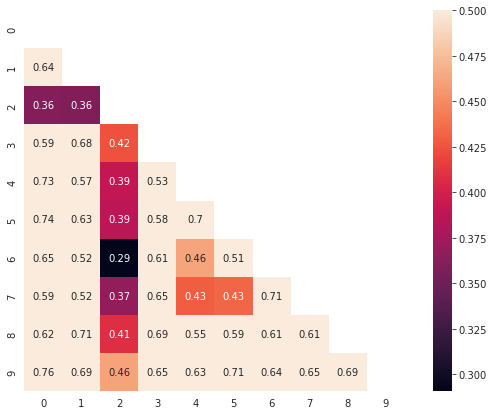

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-albert-small-v2')
model = AutoModel.from_pretrained('./binary_sim_output/sentence-transformers/paraphrase-albert-small-v2')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)

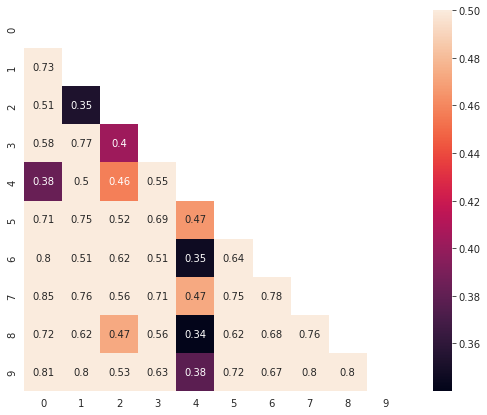

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/stsb-roberta-large')
model = AutoModel.from_pretrained('./binary_sim_output/sentence-transformers/stsb-roberta-large')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)

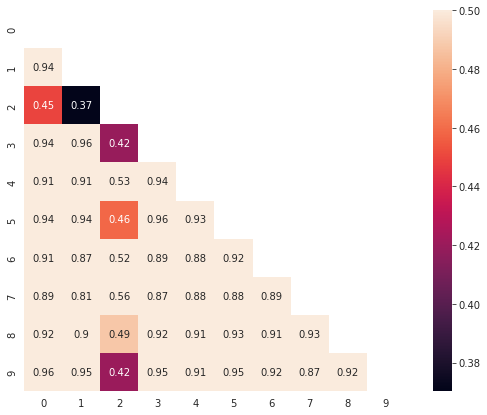

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/nli-bert-large-cls-pooling')
model = AutoModel.from_pretrained('./binary_sim_output/sentence-transformers/nli-bert-large-cls-pooling')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)